In [1]:
# Core libraries
import scanpy as sc

# Try to use GPU-accelerated rapids_singlecell, fall back to scanpy
try:
    import rapids_singlecell as rsc
    import cupy as cp
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    USE_GPU = True
    print("Using GPU-accelerated rapids_singlecell")
except ImportError:
    rsc = sc  # Use scanpy as fallback
    USE_GPU = False
    print("rapids_singlecell not available, using scanpy (CPU)")

# Data manipulation
import numpy as np
import pandas as pd
import anndata as ad

# Visualization
import matplotlib.pyplot as plt

import os
import yaml

Using GPU-accelerated rapids_singlecell


/home/ncostigan/.local/share/mamba/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize GPU memory management (only if using rapids)
if USE_GPU:
    rmm.reinitialize(
        managed_memory=False,
        pool_allocator=True,
        devices=0,
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
# =============================================================================
# CONFIGURATION - Load from config file
# =============================================================================

CONFIG_PATH = "config/preprocess.yaml"

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract config values
SAMPLE_NAMES = config['sample_names']
INPUT_DIR = config['input_dir']
OUTPUT_DIR = config['output_dir']
OUTPUT_PREFIX = config['output_prefix']

# Preprocessing parameters
MIN_COUNTS_PER_CELL = config['preprocessing']['min_counts_per_cell']
MIN_CELLS_PER_GENE = config['preprocessing']['min_cells_per_gene']
NORMALIZE_TARGET_SUM = config['preprocessing']['normalize_target_sum']
SCALE_MAX_VALUE = config['preprocessing']['scale_max_value']

# PCA parameters
MIN_PCS = config.get('pca', {}).get('min_pcs', None)

# Clustering parameters
LEIDEN_RESOLUTION = config['clustering']['leiden_resolution']

print(f"Loaded config from {CONFIG_PATH}")
print(f"Samples: {SAMPLE_NAMES}")
print(f"Min PCs: {MIN_PCS}")

Loaded config from config/preprocess.yaml
Samples: ['core_01', 'core_03', 'core_06', 'core_08', 'core_09', 'core_11', 'core_12', 'core_14', 'core_15']
Min PCs: 10


In [4]:
# Set up plot output directory
sc.settings.figdir = os.path.join(OUTPUT_DIR, 'plots/preprocess')
os.makedirs(sc.settings.figdir, exist_ok=True)

In [5]:
# Load all samples
adatas = []
for sample_name in SAMPLE_NAMES:
    filepath = os.path.join(INPUT_DIR, f"{sample_name}.h5ad")
    print(f"Loading {filepath}...")
    adata = sc.read_h5ad(filepath)
    adata.obs['sample'] = sample_name
    adatas.append(adata)
    
print(f"Loaded {len(adatas)} samples")

Loading ./datasets/tma/good_cores/cp18_tma_1/core_01.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_03.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_06.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_08.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_09.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_11.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_12.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_14.h5ad...
Loading ./datasets/tma/good_cores/cp18_tma_1/core_15.h5ad...
Loaded 9 samples


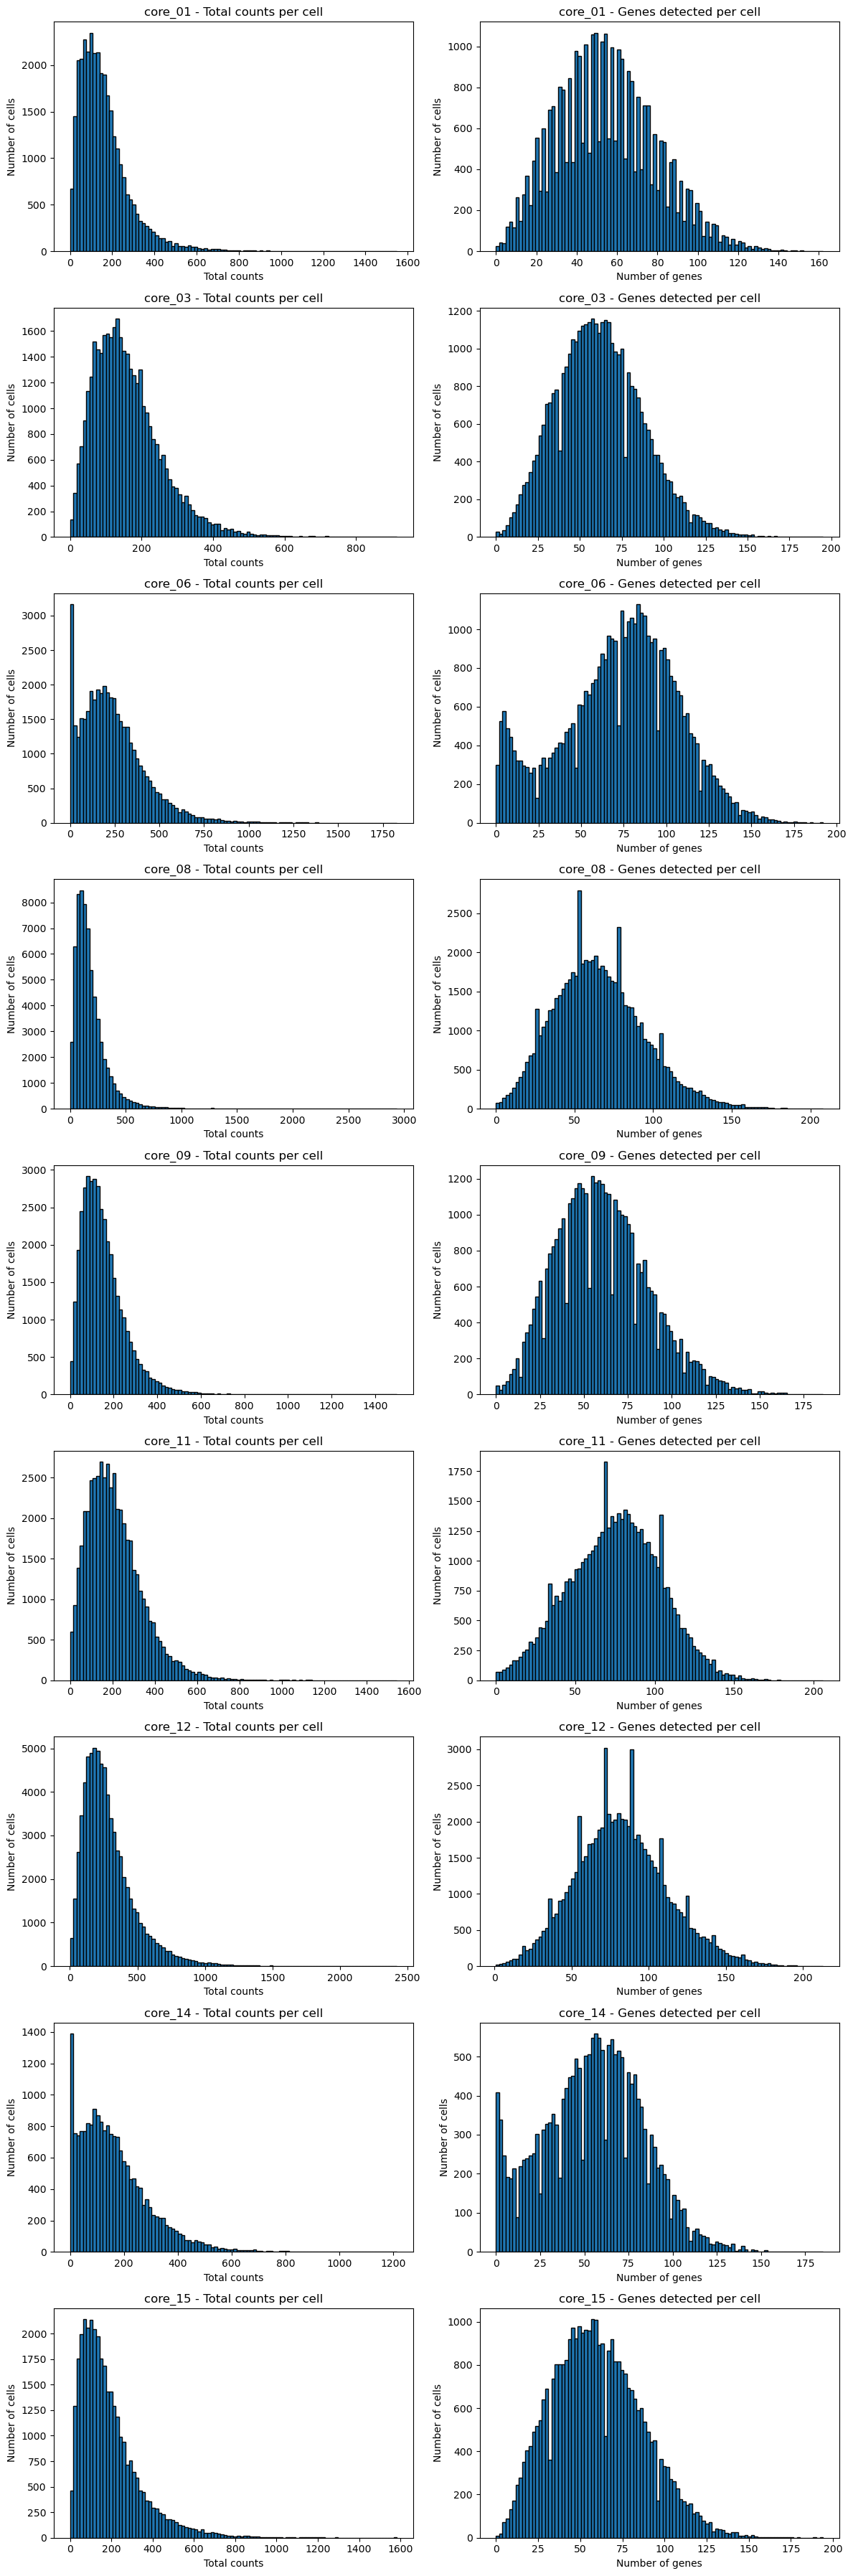


core_01:
  Total counts - median: 134, mean: 160
  Genes detected - median: 53, mean: 55

core_03:
  Total counts - median: 144, mean: 161
  Genes detected - median: 60, mean: 62

core_06:
  Total counts - median: 211, mean: 239
  Genes detected - median: 76, mean: 73

core_08:
  Total counts - median: 144, mean: 181
  Genes detected - median: 63, mean: 65

core_09:
  Total counts - median: 131, mean: 152
  Genes detected - median: 59, mean: 61

core_11:
  Total counts - median: 190, mean: 211
  Genes detected - median: 76, mean: 75

core_12:
  Total counts - median: 242, mean: 288
  Genes detected - median: 81, mean: 82

core_14:
  Total counts - median: 138, mean: 164
  Genes detected - median: 56, mean: 55

core_15:
  Total counts - median: 153, mean: 190
  Genes detected - median: 58, mean: 60


In [6]:
# Calculate and plot QC metrics for each sample
fig, axes = plt.subplots(len(adatas), 2, figsize=(12, 4 * len(adatas)))
if len(adatas) == 1:
    axes = axes.reshape(1, -1)

for i, (adata, sample_name) in enumerate(zip(adatas, SAMPLE_NAMES)):
    if USE_GPU:
        rsc.get.anndata_to_GPU(adata)
    
    rsc.pp.calculate_qc_metrics(adata)
    
    # Plot total_counts
    axes[i, 0].hist(adata.obs['total_counts'], bins=100, edgecolor='black')
    axes[i, 0].set_xlabel('Total counts')
    axes[i, 0].set_ylabel('Number of cells')
    axes[i, 0].set_title(f'{sample_name} - Total counts per cell')
    
    # Plot n_genes_by_counts
    axes[i, 1].hist(adata.obs['n_genes_by_counts'], bins=100, edgecolor='black')
    axes[i, 1].set_xlabel('Number of genes')
    axes[i, 1].set_ylabel('Number of cells')
    axes[i, 1].set_title(f'{sample_name} - Genes detected per cell')

plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_qc_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
for adata, sample_name in zip(adatas, SAMPLE_NAMES):
    total_counts = adata.obs['total_counts']
    n_genes = adata.obs['n_genes_by_counts']
    print(f"\n{sample_name}:")
    print(f"  Total counts - median: {np.median(total_counts):.0f}, mean: {np.mean(total_counts):.0f}")
    print(f"  Genes detected - median: {np.median(n_genes):.0f}, mean: {np.mean(n_genes):.0f}")

In [7]:
# Preprocess all samples
for adata in adatas:
    # Filter and normalize
    rsc.pp.filter_cells(adata, min_counts=MIN_COUNTS_PER_CELL)
    rsc.pp.filter_genes(adata, min_cells=MIN_CELLS_PER_GENE)
    adata.layers['counts'] = adata.X.copy()
    rsc.pp.normalize_total(adata, target_sum=NORMALIZE_TARGET_SUM)
    rsc.pp.log1p(adata)
    rsc.pp.scale(adata, max_value=SCALE_MAX_VALUE)

print("Preprocessing complete")

filtered out 1021 cells that have less than 20 counts
filtered out 545 cells that have less than 20 counts
filtered out 3271 cells that have less than 20 counts
filtered out 1232 cells that have less than 20 counts
filtered out 748 cells that have less than 20 counts
filtered out 812 cells that have less than 20 counts
filtered out 394 cells that have less than 20 counts
filtered out 1831 cells that have less than 20 counts
filtered out 3 genes that are detected in less than 5 cells
filtered out 739 cells that have less than 20 counts
Preprocessing complete


In [8]:
# Merge the datasets
if len(adatas) == 1:
    adata = adatas[0]
else:
    adata = adatas[0].concatenate(adatas[1:], batch_key='sample')
    # Rename batch categories to sample names
    sample_name_map = {str(i): name for i, name in enumerate(SAMPLE_NAMES)}
    adata.obs['sample'] = adata.obs['sample'].cat.rename_categories(sample_name_map)

# Define output filenames
merged_sample_name = f"{OUTPUT_PREFIX}_merged"
integrated_sample_name = f"{OUTPUT_PREFIX}_integrated"
processed_sample_name = f"{OUTPUT_PREFIX}_processed"

print(f"Merged dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")

/tmp/ipykernel_3535847/1570296472.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key='sample')


Merged dataset: 383738 cells x 443 genes


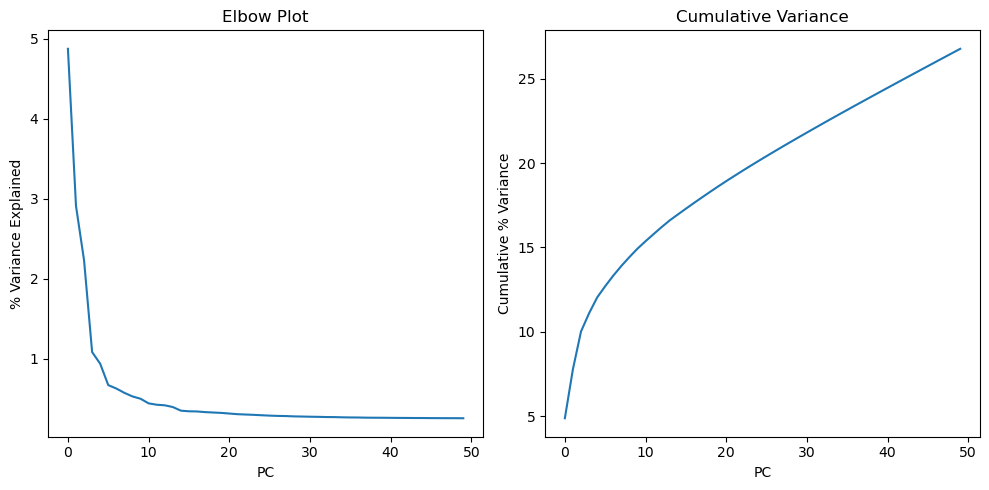

First 10 variance percentages: [4.87518401 2.91051338 2.22971841 1.08251566 0.93624664 0.66930004
 0.62656392 0.57248064 0.52785732 0.49883192]
First 10 cumulative variances: [ 4.87518401  7.78569739 10.0154158  11.09793146 12.0341781  12.70347814
 13.33004206 13.9025227  14.43038002 14.92921194]
First criterion (co1): 50
Second criterion (co2): 5
Auto-calculated PCs: 5
Applying min_pcs=10, final PCs: 10


In [9]:
rsc.tl.pca(adata)

# Get the variance explained by each PC
pct = adata.uns['pca']['variance_ratio'] * 100
# Calculate cumulative variance
cumu = np.cumsum(pct)

# Diagnostic plots to understand the distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pct)
plt.xlabel('PC')
plt.ylabel('% Variance Explained')
plt.title('Elbow Plot')

plt.subplot(1, 2, 2)
plt.plot(cumu)
plt.xlabel('PC')
plt.ylabel('Cumulative % Variance')
plt.title('Cumulative Variance')
plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/{merged_sample_name}_pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the first few values to inspect
print("First 10 variance percentages:", pct[:10])
print("First 10 cumulative variances:", cumu[:10])

# Find first PC where cumulative percent > 90% and individual percent < 5%
co1_candidates = np.where((cumu > 90) & (pct < 5))[0]
co1 = co1_candidates[0] if len(co1_candidates) > 0 else len(pct)
print(f"First criterion (co1): {co1}")

# Calculate differences between consecutive PCs
pct_diff = pct[:-1] - pct[1:]
# Find where the difference is greater than 0.1%
co2_candidates = np.where(pct_diff > 0.1)[0]
co2 = co2_candidates[-1] + 1 if len(co2_candidates) > 0 else len(pct)
print(f"Second criterion (co2): {co2}")

# Get minimum of the two calculations
pcs_auto = min(co1, co2)
print(f"Auto-calculated PCs: {pcs_auto}")

# Apply minimum PCs constraint if configured
if MIN_PCS is not None:
    pcs = max(pcs_auto, MIN_PCS)
    print(f"Applying min_pcs={MIN_PCS}, final PCs: {pcs}")
else:
    pcs = pcs_auto
    print(f"Using auto-calculated PCs: {pcs}")

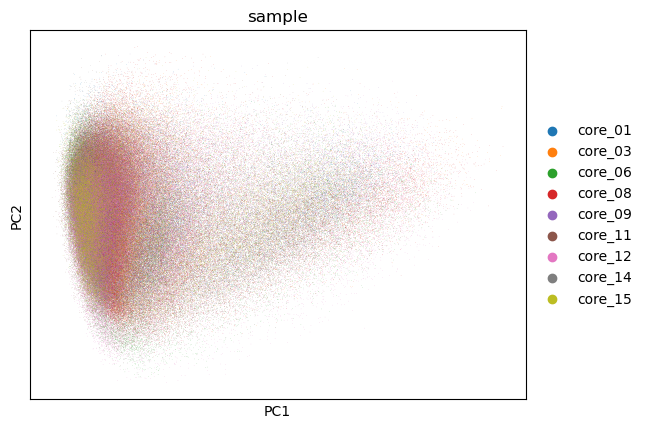

In [10]:
# Plot PCA to visualize batch effects (if multiple samples)
if len(SAMPLE_NAMES) > 1:
    sc.pl.pca(adata, color="sample", save=f'_{merged_sample_name}_sample.png')
else:
    sc.pl.pca(adata, save=f'_{merged_sample_name}.png')

In [11]:
# Batch correction with Harmony (only if multiple samples)
if len(SAMPLE_NAMES) > 1:
    if USE_GPU:
        rsc.pp.harmony_integrate(adata, "sample")
    else:
        sc.external.pp.harmony_integrate(adata, "sample")
    pca_rep = "X_pca_harmony"
else:
    pca_rep = "X_pca"

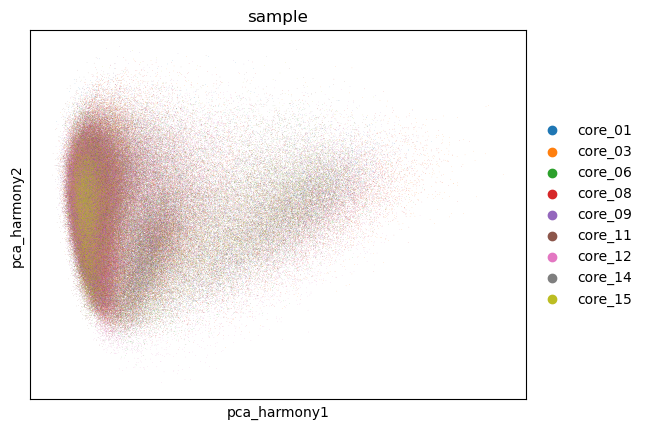

In [12]:
# Plot integrated PCA (if batch correction was applied)
if len(SAMPLE_NAMES) > 1:
    sc.pl.embedding(adata, basis='pca_harmony', color='sample', save=f'_{integrated_sample_name}_sample.png')

In [13]:
# Compute neighbors using appropriate representation
rsc.pp.neighbors(adata, use_rep=pca_rep, n_pcs=pcs)

In [14]:
rsc.tl.umap(adata)

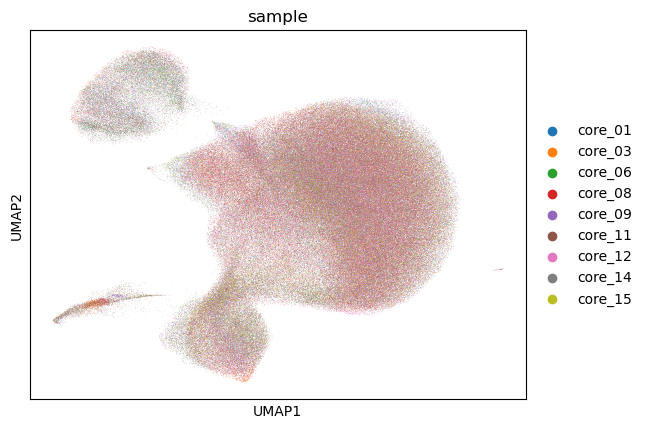

In [15]:
# Plot UMAP colored by sample
if len(SAMPLE_NAMES) > 1:
    sc.pl.umap(adata, color=["sample"], wspace=0.4, save=f'_{integrated_sample_name}_sample.png')
else:
    sc.pl.umap(adata, save=f'_{integrated_sample_name}.png')

In [16]:
# Leiden clustering
rsc.tl.leiden(adata, resolution=LEIDEN_RESOLUTION)
adata.obs["leiden"].value_counts()

leiden
14    51523
9     35064
8     34405
16    32872
10    26206
15    21153
17    21007
12    20719
4     17856
11    17677
1     17025
13    16643
0     15803
3     14060
2     13856
5     13385
7      9619
6      4865
Name: count, dtype: int64

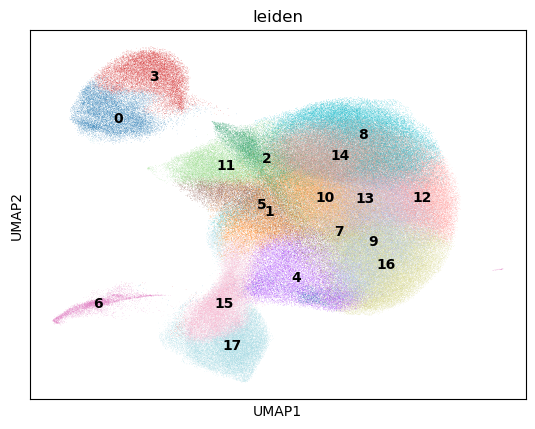

In [17]:
sc.pl.umap(
    adata,
    color=[
        "leiden",
    ],
    wspace=0.4,
    legend_loc="on data",
    save=f'_{integrated_sample_name}_leiden.png'
)

In [18]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

In [19]:
# Save the processed dataset
output_path = os.path.join(OUTPUT_DIR, f'{processed_sample_name}.h5ad')
sc.write(output_path, adata)
print(f"Saved to {output_path}")

Saved to ./tma_processed.h5ad
